Here we select stars in the GD-1 stream using a simple proper-motion cut combined with a color-magnitude filter using a metal-poor isochrone:

In [1]:
from os import path

# Third-party
import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity

from pyia import GaiaData
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp

This is the full table of Gaia data + Pan-STARRs photometry for the region around GD-1:

In [2]:
t = Table.read('../data/gd1-all-ps1-red.fits')

In [3]:
# deredden
bands = ['g', 'r', 'i', 'z', 'y']
for band in bands:
    t[band + '0'] = t[band] - t['A_{}'.format(band)]

In [4]:
g = GaiaData(t)
c_tmp = g.get_skycoord(distance=False)

### Convert to GD-1 coordinates and reflex correct

We assign distances to the stars using the orbit from Koposov et al. 2010:

In [5]:
gc_frame = coord.Galactocentric(galcen_distance=8*u.kpc, z_sun=0*u.pc)
pot = gp.load('../output/mwpot.yml')

In [6]:
phi1_0 = 20. * u.deg
phi2, d, pm1, pm2, vr = [-3.47508128, 12.26167861, -5.70045271, -1.44728289, -326.96300355]
c0 = gc.GD1(phi1=phi1_0, phi2=phi2*u.deg, distance=d*u.kpc, 
            pm_phi1_cosphi2=pm1*u.mas/u.yr,
            pm_phi2=pm2*u.mas/u.yr,
            radial_velocity=vr*u.km/u.s)
w0 = gd.PhaseSpacePosition(c0.transform_to(gc_frame).cartesian)

orbit = pot.integrate_orbit(w0, dt=-0.2*u.Myr, n_steps=300)
orbit = pot.integrate_orbit(orbit[-1], dt=0.2*u.Myr, n_steps=1000)
orbit_c = orbit.to_coord_frame(gc.GD1, galactocentric_frame=gc_frame)
orbit_gd1 = gc.reflex_correct(orbit_c)

Use interpolation to compute distance at any phi1:

Text(0,0.5,'DM')

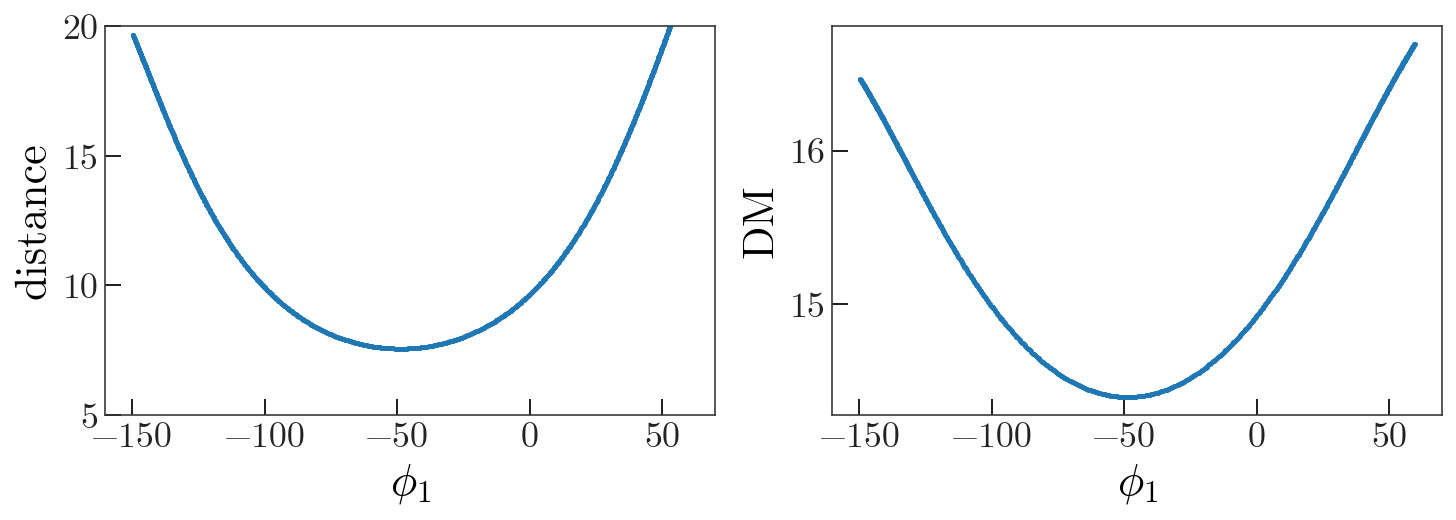

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), 
                         sharex=True, constrained_layout=True)
axes[0].plot(orbit_c.phi1.wrap_at(180*u.deg),
             orbit_c.distance)
axes[0].set_xlabel(r'$\phi_1$')
axes[0].set_ylabel('distance')
axes[0].set_ylim(5, 20)

axes[1].plot(orbit_c.phi1.wrap_at(180*u.deg),
             orbit_c.distance.distmod)
axes[1].set_xlabel(r'$\phi_1$')
axes[1].set_ylabel('DM')

In [8]:
_dist_func = interp1d(orbit_c.phi1.wrap_at(180*u.deg).degree, 
                      orbit_c.distance.to(u.kpc).value)
def dist_func(phi1):
    phi1 = coord.Angle(phi1)
    return coord.Distance(_dist_func(phi1.wrap_at(180*u.deg).degree) * u.kpc)

In [214]:
tmp = c_tmp.transform_to(gc.GD1).phi1
c = g.get_skycoord(distance=dist_func(tmp), 
                   radial_velocity=0*u.km/u.s)

gd1_c_raw = c.transform_to(gc.GD1)
gd1_c = gc.reflex_correct(gd1_c_raw)

In [10]:
phi1 = gd1_c.phi1.wrap_at(180*u.deg)
phi2 = gd1_c.phi2
pm1 = gd1_c.pm_phi1_cosphi2
pm2 = gd1_c.pm_phi2

## Color magnitude selection:

Inial proper motion cut to roughly select stream stars

In [11]:
pm1_min = -9*u.mas/u.yr
pm1_max = -4.*u.mas/u.yr
pm2_min = -1.7*u.mas/u.yr
pm2_max = 1.*u.mas/u.yr
pm_mask1 = ((pm1 < pm1_max) & (pm1 > pm1_min) & 
            (pm2 < pm2_max) & (pm2 > pm2_min))

Isochrone for CMD selection:

In [12]:
iso = Table.read('../data/mist_12.0_-1.35.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<3)
iso = iso[phasecut]

### First figure out what distance modulus and range of DM we should be sensitive to:

We use the orbit fit to look at the range of distance over this region

In [13]:
_phi1 = orbit_c.phi1.wrap_at(180*u.deg)
_phi1_mask = (_phi1 > -80*u.deg) & (_phi1 < 20*u.deg)
orbit_dm = orbit_c.distance.distmod[_phi1_mask]
med_dm = np.median(orbit_dm)
ptp_dm = np.ptp(orbit_dm)
print('min, max = ', orbit_dm.min(), orbit_dm.max())
print('med, range = ', med_dm, ptp_dm)

min, max =  14.388904141182788 mag 15.442749643456754 mag
med, range =  14.583826435874633 mag 1.0538455022739655 mag


In [187]:
# i_gi = iso['PS_g'] - iso['PS_i']
# i_g = iso['PS_g'] + med_dm.value

# i_left = i_gi - 0.2*(i_g/22)**5
# i_right = i_gi + 0.3*(i_g/23)**5

# poly = np.hstack([np.array([i_left, i_g - 0.5/2.]), 
#                   np.array([i_right[::-1], i_g[::-1] + 0.5/2.])]).T
# ind = (poly[:,1]<21.3) & (poly[:,1]>15.5)
# poly_main = poly[ind]
# cmd_path_main = mpl.path.Path(poly_main)

# distance modulus
dm = coord.Distance(7.8*u.kpc).distmod.value

# main sequence + rgb
i_gi = iso['PS_g']-iso['PS_i']
i_g = iso['PS_g']+dm

i_left_gi = i_gi - 0.5*(i_g/28)**5
i_right_gi = i_gi + 0.55*(i_g/28)**5
# A = np.exp(-0.5 * ((i_gi - 0.4)**2/0.2**2 + (i_g - 18)**2/0.5**2))
# i_left_g = i_g - 0.2 * A
# i_right_g = i_g + 0.2 * A
i_left_g = i_g
i_right_g = i_g

poly = np.hstack([np.array([i_left_gi, i_left_g]), np.array([i_right_gi[::-1], i_right_g[::-1]])]).T
ind = (poly[:,1]<21.) & (poly[:,1]>17.8)
poly_main = poly[ind]
cmd_path_main = mpl.path.Path(poly_main)

In [188]:
on_mask = np.abs(phi2-0.5*u.deg) < 1.5*u.deg
off_mask = np.abs(phi2-3.5*u.deg) < 1.5*u.deg

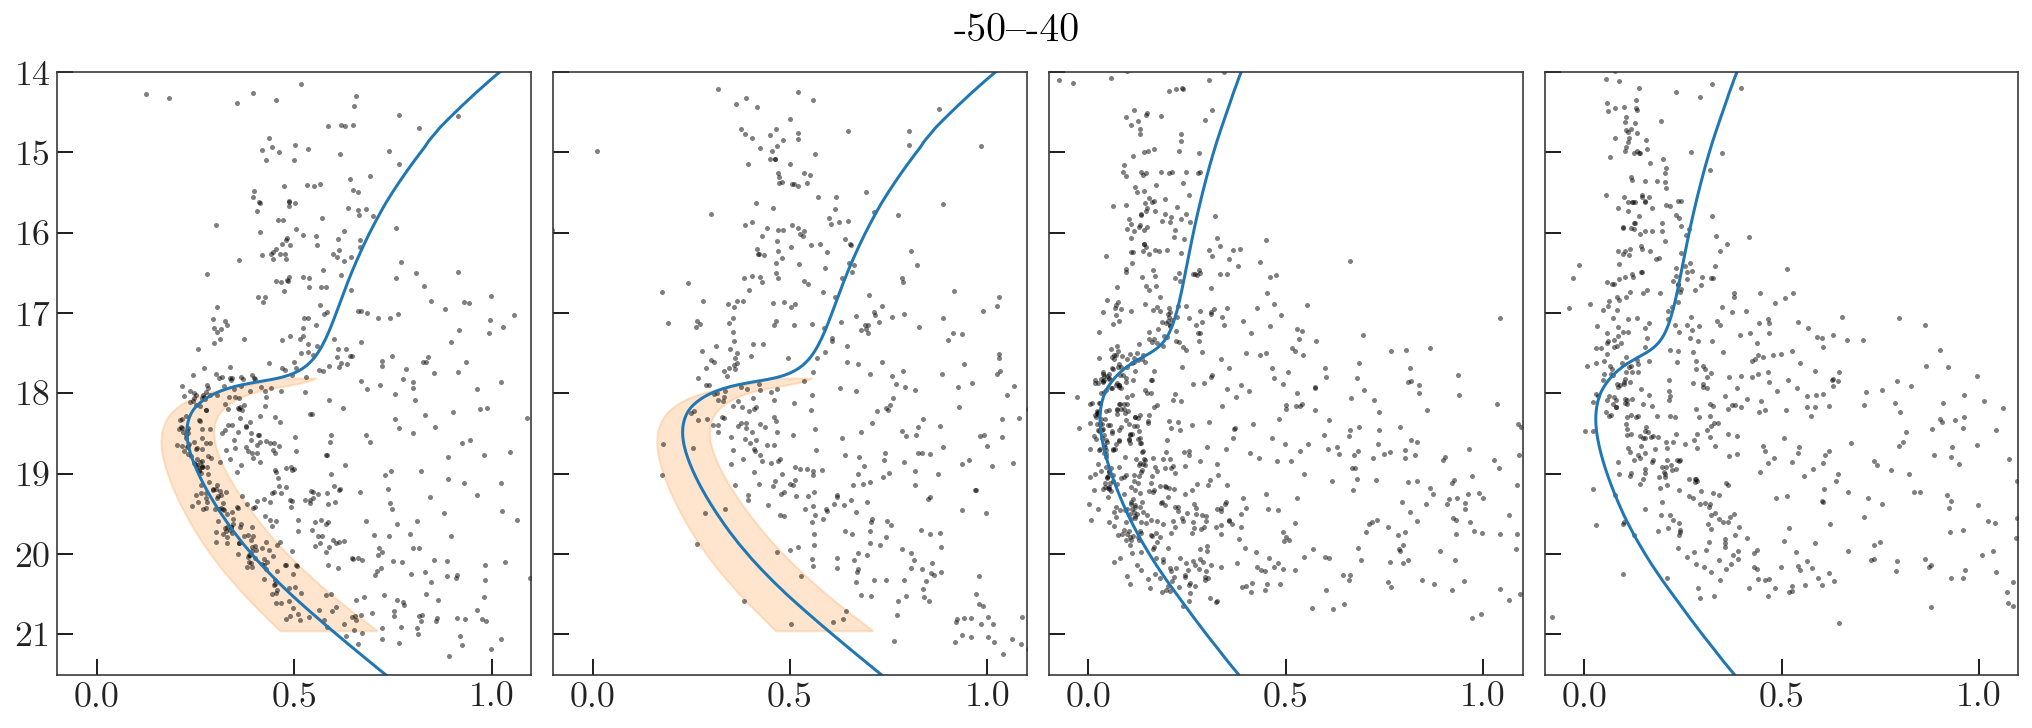

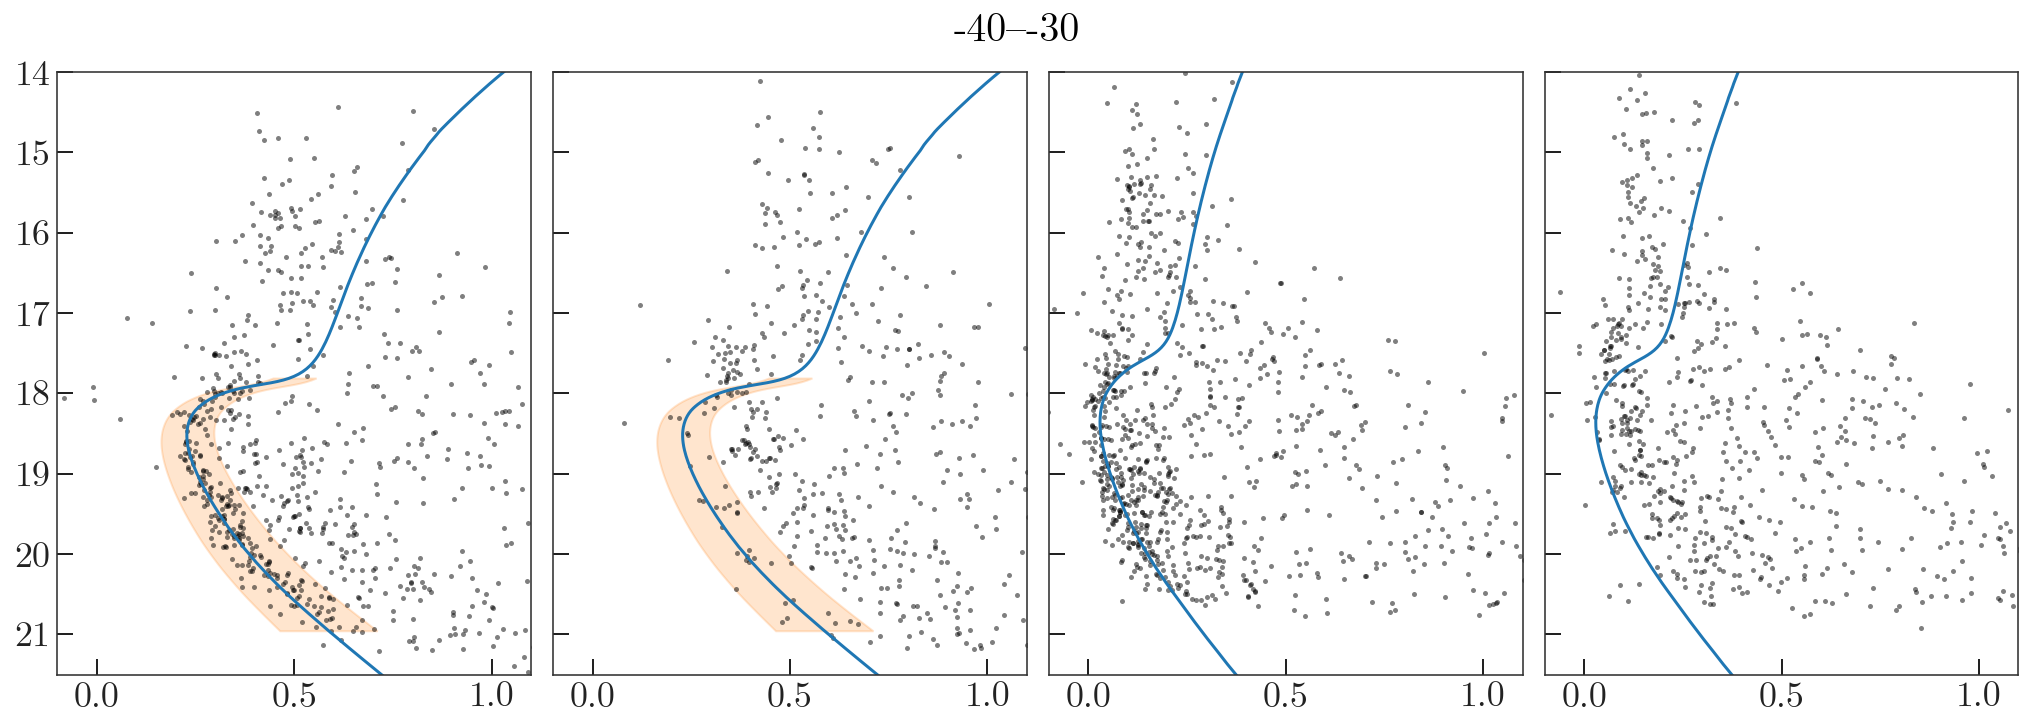

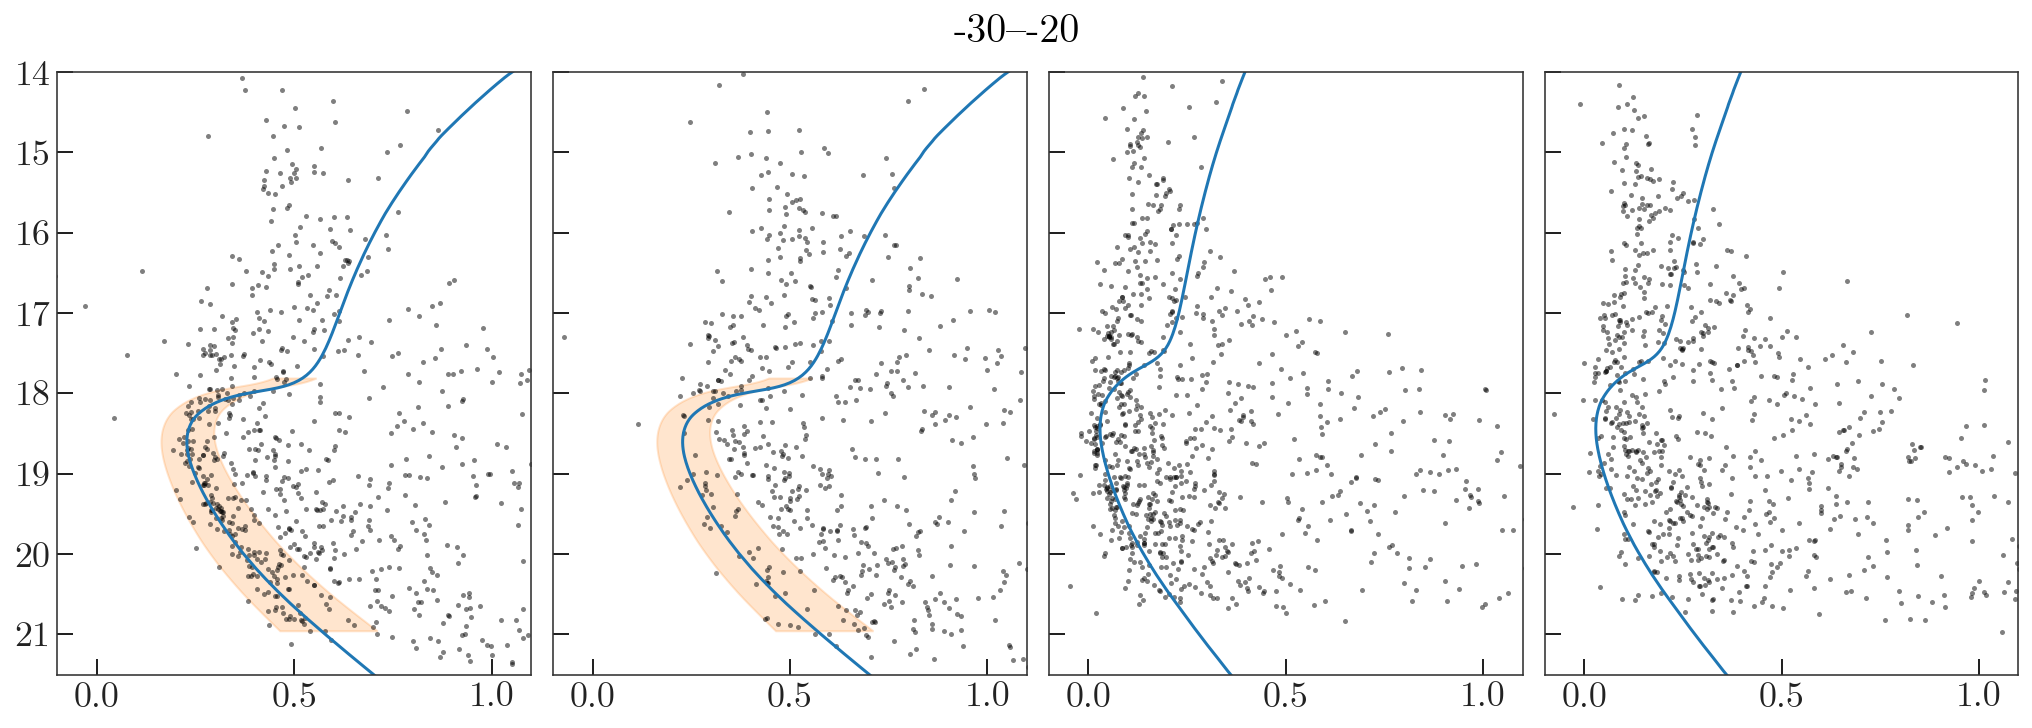

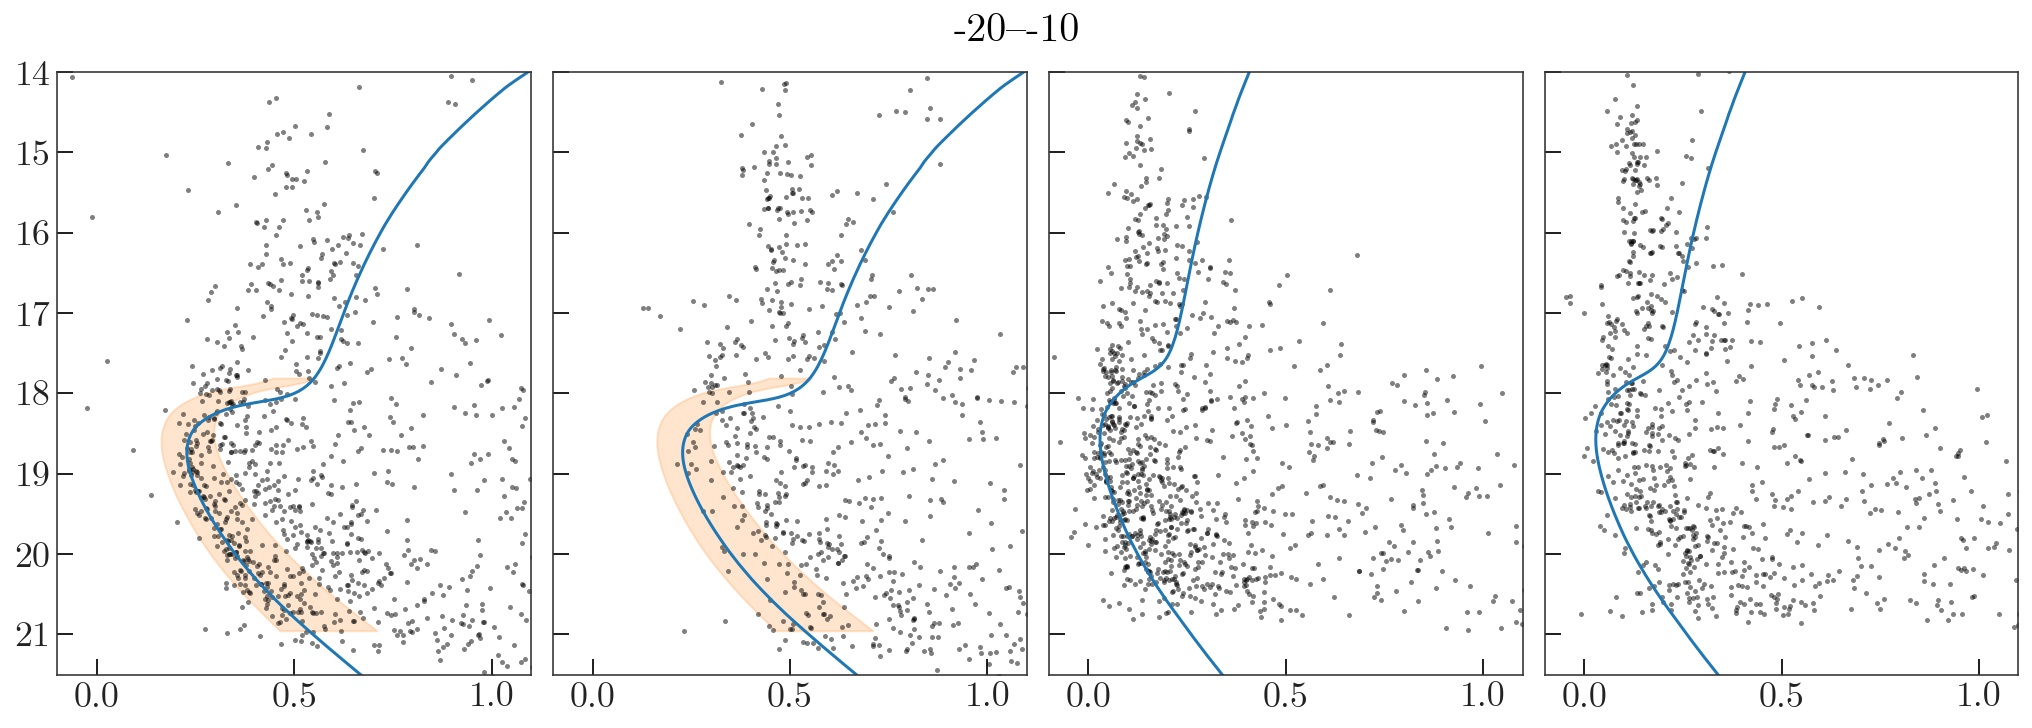

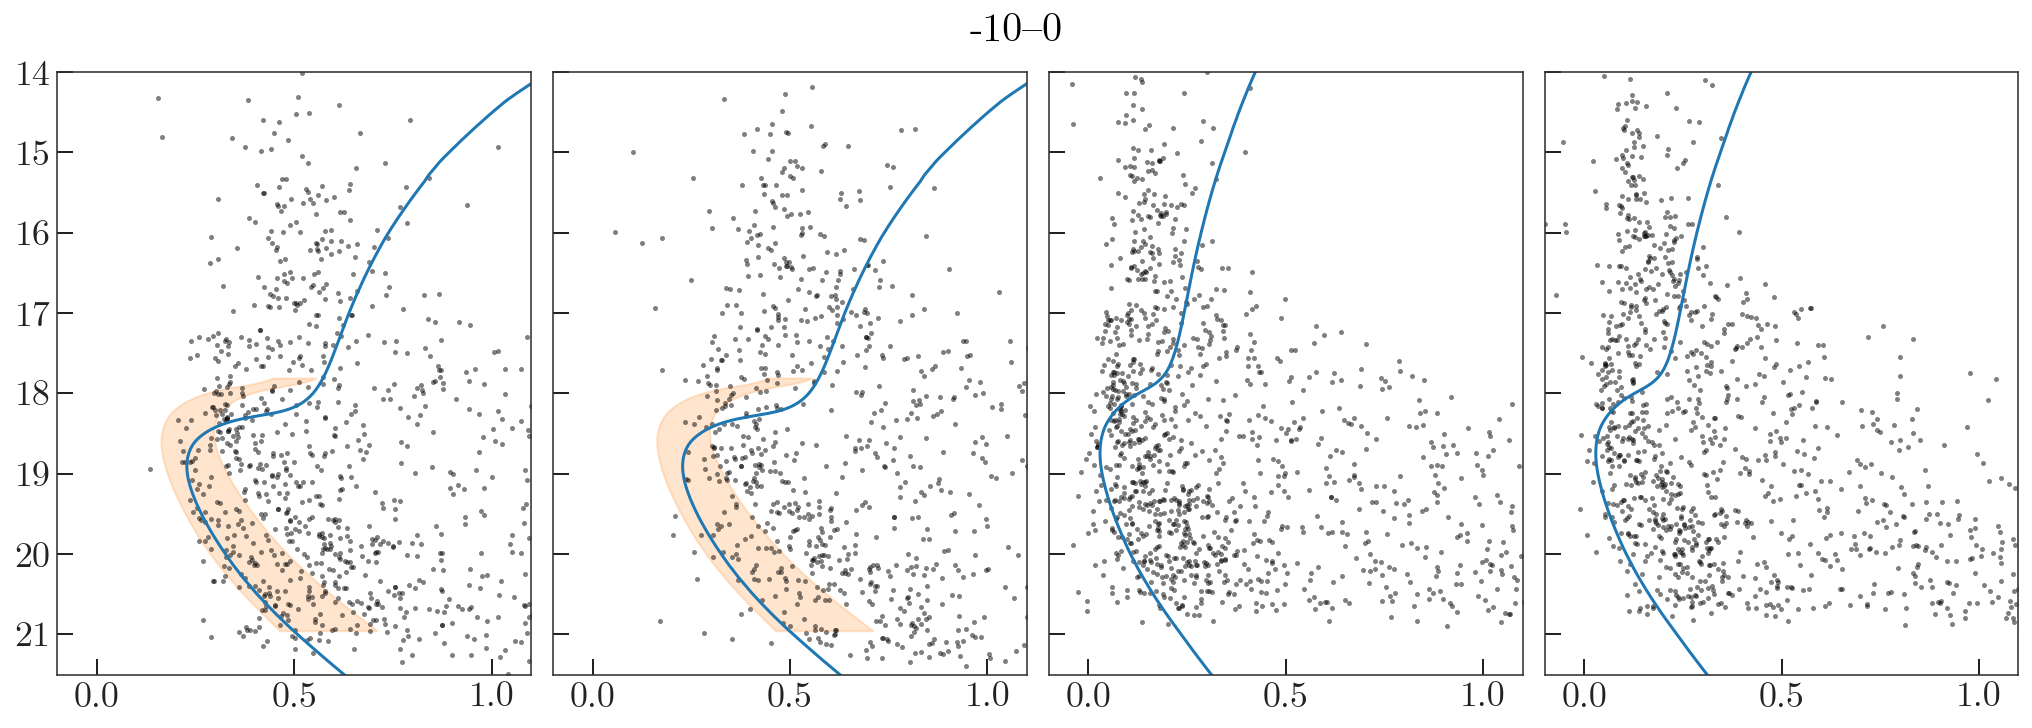

In [189]:
for l in np.arange(-50, -10+1e-3, 10):
    phi_mask1 = (phi1 > l*u.deg) & (phi1 < (l+10)*u.deg)

    init_stream_mask = pm_mask1 & phi_mask1 & on_mask
    init_ctrl_mask = pm_mask1 & phi_mask1 & off_mask

    mean_DM = np.mean(gd1_c.distance[init_stream_mask]).distmod.value
    fig, axes = plt.subplots(1, 4, figsize=(14, 5),
                             constrained_layout=True, 
                             sharex=True, sharey=True)

    for i, mask in enumerate([init_stream_mask, init_ctrl_mask]):
        ax = axes[i]
        ax.plot(g.g0[mask] - g.i0[mask], g.g0[mask], 
                color='k', marker='.', alpha=0.5, ls='none')

        ax.plot(iso['PS_g']-iso['PS_i'],
                iso['PS_g'] + mean_DM, 
                marker='')
        
        p = mpl.patches.Polygon(cmd_path_main.vertices, 
                                alpha=0.2, color='tab:orange')
        ax.add_patch(p)

    for i, mask in enumerate([init_stream_mask, init_ctrl_mask]):
        ax = axes[i+2]
        ax.plot(g.r0[mask] - g.z0[mask], g.r0[mask], 
                color='k', marker='.', alpha=0.5, ls='none')

        ax.plot(iso['PS_r']-iso['PS_z'],
                iso['PS_r'] + mean_DM, 
                marker='')

    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(21.5, 14)
    fig.suptitle('{0:.0f}–{1:.0f}'.format(l, l+10), fontsize=20)

In [190]:
points = np.vstack((g.g0 - g.i0, g.g0)).T
cmd_mask = cmd_path_main.contains_points(points)

In [191]:
cmd_mask.sum()

383048

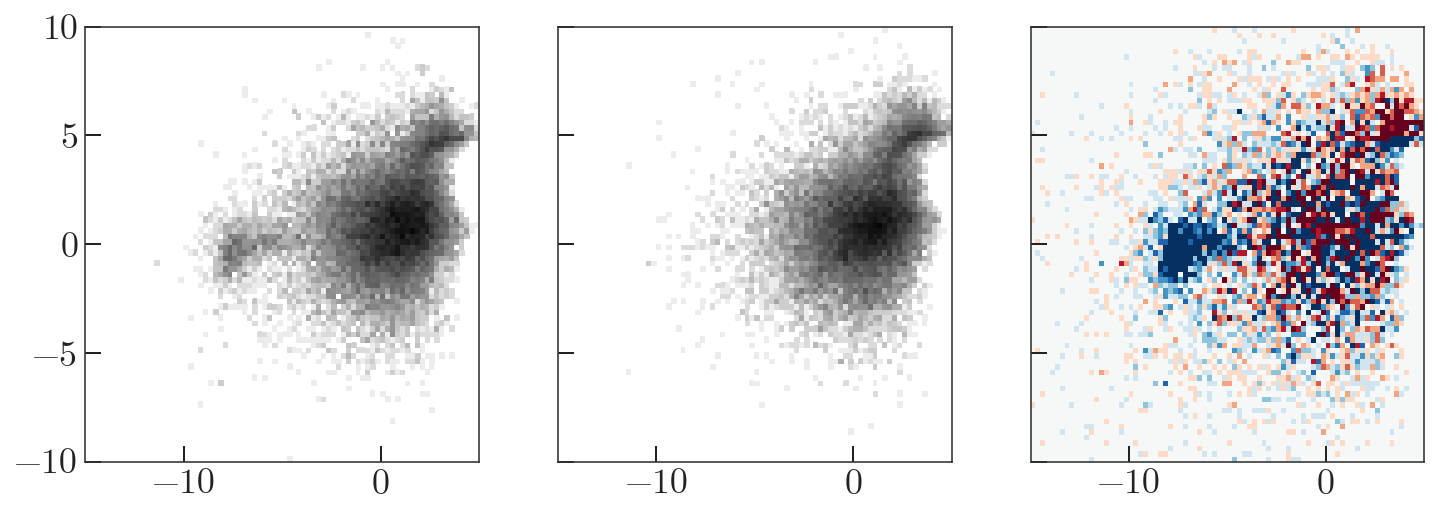

In [192]:
bins = (np.arange(-15, 5+1e-3, 0.25),
        np.arange(-10, 10+1e-3, 0.25))
norm = mpl.colors.LogNorm(vmin=1, vmax=100)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), 
                       sharex=True, sharey=True)

ax = axes[0]
_ph = (phi1 > -80*u.deg) & (phi1 < 10*u.deg) & (np.abs(phi2) < 1.5*u.deg)
X1 = np.vstack((pm1.value[cmd_mask & _ph], pm2.value[cmd_mask & _ph])).T
Xerr1 = g[cmd_mask & _ph].get_cov()[:, 3:5, 3:5]
H1, xe, ye = np.histogram2d(X1[:, 0], X1[:, 1],
                            bins=bins)
ax.pcolormesh(xe, ye, H1.T, cmap='Greys', norm=norm)
ax.set_xlim(-15, 5)
ax.set_ylim(-10, 10)

ax = axes[1]
_ph = (phi1 > -80*u.deg) & (phi1 < 10*u.deg) & (np.abs(phi2-3.5*u.deg) < 1.5*u.deg)
X2 = np.vstack((pm1.value[cmd_mask & _ph], pm2.value[cmd_mask & _ph])).T
Xerr2 = g[cmd_mask & _ph].get_cov()[:, 3:5, 3:5]
H2, xe, ye = np.histogram2d(X2[:, 0], X2[:, 1],
                            bins=bins)
ax.pcolormesh(xe, ye, H2.T, cmap='Greys', norm=norm)

ax = axes[2]
ax.pcolormesh(xe, ye, (H1 - H2).T, 
              cmap='RdBu', vmin=-5, vmax=5)

In [194]:
bw = 0.45
kernel = 'epanechnikov'
# kernel = 'gaussian'

kde1 = KernelDensity(bandwidth=bw, kernel=kernel)
_ = kde1.fit(X1)

kde2 = KernelDensity(bandwidth=bw, kernel=kernel)
_ = kde2.fit(X2)

In [195]:
xgrid, ygrid = np.meshgrid(np.linspace(-15, 5, 128), np.linspace(-10, 10, 128))

In [196]:
gridX = np.vstack((xgrid.ravel(), ygrid.ravel())).T

In [197]:
gridH1 = kde1.score_samples(gridX)
gridH1 = gridH1.reshape(xgrid.shape)

gridH2 = kde2.score_samples(gridX)
gridH2 = gridH2.reshape(xgrid.shape)

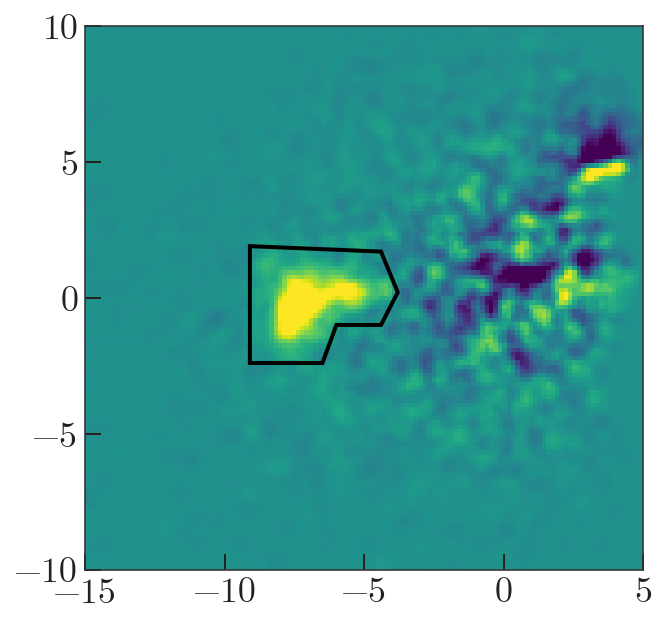

In [218]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(xgrid, ygrid, np.exp(gridH1) - np.exp(gridH2), 
              vmin=-5e-3, vmax=5e-3)

# shape
nodes = np.array([[-9.1, -2.4],
                  [-6.5, -2.4],
                  [-6, -1],
                  [-4.4, -1],
                  [-3.8, 0.2],
                  [-4.4, 1.7],
                  [-9.1, 1.9]])
np.save('../output/pm_poly_nodes.npy', nodes)
pp = mpl.patches.Polygon(nodes, 
                         facecolor='none', edgecolor='k', linewidth=2)

# rectangle
# nodes = np.array([[-9, -1.7],
#                   [-4.5, -1.7],
#                   [-4.5, 1],
#                   [-9, 1]])
# pp = mpl.patches.Polygon(nodes, 
#                          facecolor='none', edgecolor='k', linewidth=2)

ax.add_patch(pp)

In [207]:
pm_points = np.vstack((pm1.value, pm2.value)).T
pm_mask = pp.get_path().contains_points(pm_points)

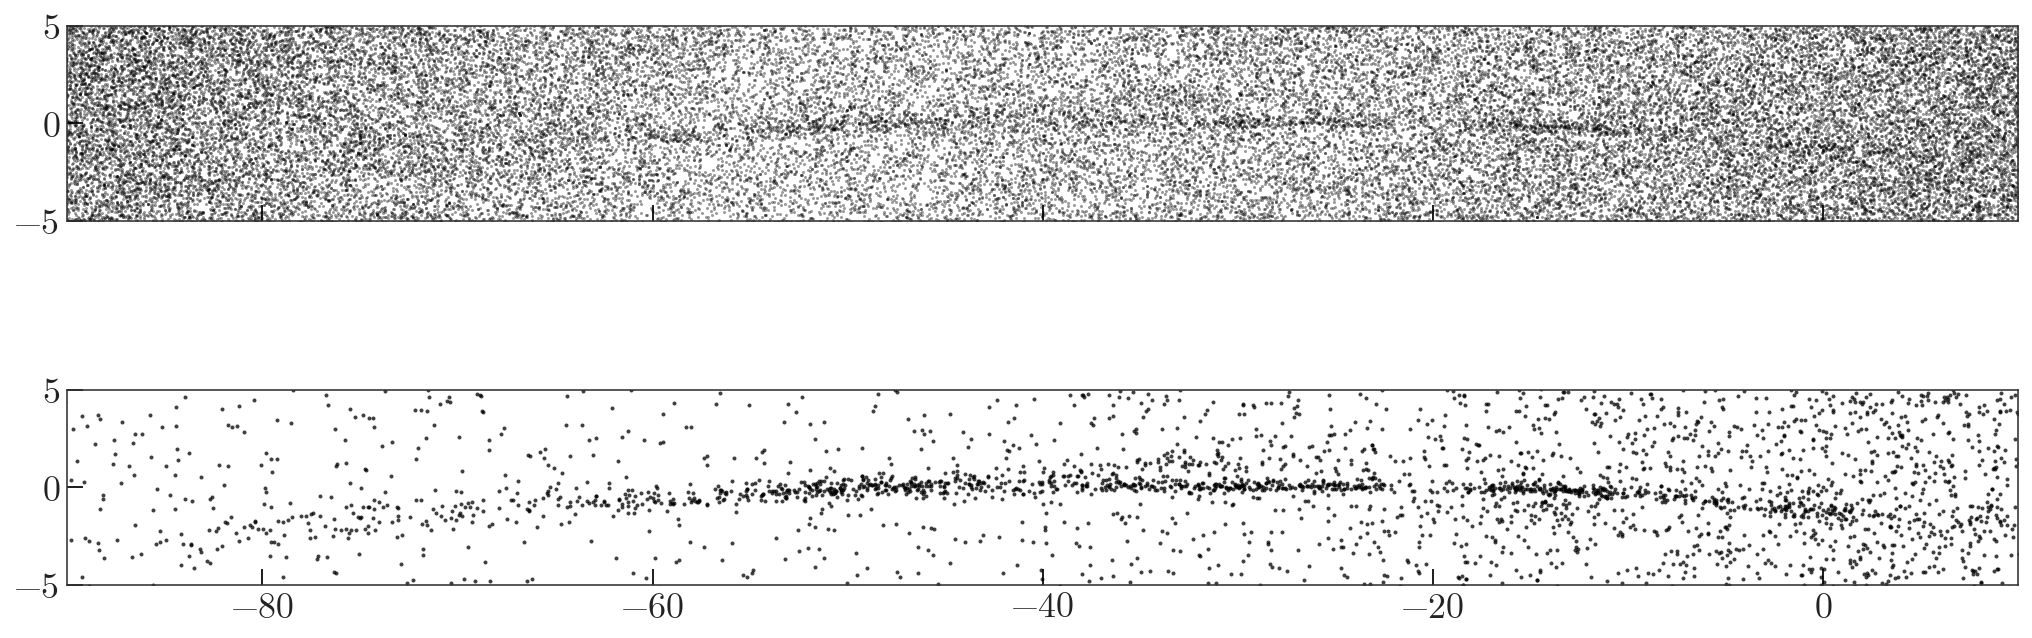

In [208]:
fig, axes = plt.subplots(2, 1, figsize=(14, 5), 
                         sharex=True, sharey=True,
                         constrained_layout=True)

ax = axes[0]
ax.plot(phi1[pm_mask], phi2[pm_mask], 
        marker='o', ms=1.5, ls='none', alpha=0.4, c='k')

# ax.axhline(2, color='r')
# ax.axhline(-1, color='r')

ax = axes[1]
ax.plot(phi1[cmd_mask & pm_mask], phi2[cmd_mask & pm_mask], 
        marker='o', ms=2, ls='none', alpha=0.75, c='k')

# xxx = 50000
# ax.plot(np.random.uniform(-100, 25, xxx),
#         np.random.uniform(-10, 5, xxx),
#         marker='o', ms=1.5, ls='none', alpha=0.4, c='k')
# ax.plot(phi1[cmd_mask & pm_mask], phi2[cmd_mask & pm_mask], 
#         marker='o', ms=1.5, ls='none', alpha=0.4, c='k')

# ax.set_xlim(-100, 25)
# ax.set_ylim(-10, 5)
ax.set_xlim(-90, 10)
ax.set_ylim(-5, 5)

for ax in axes:
    ax.set_aspect('equal')

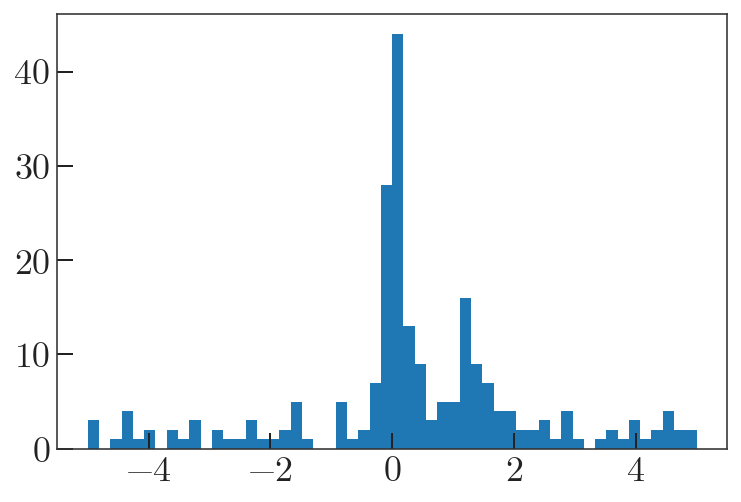

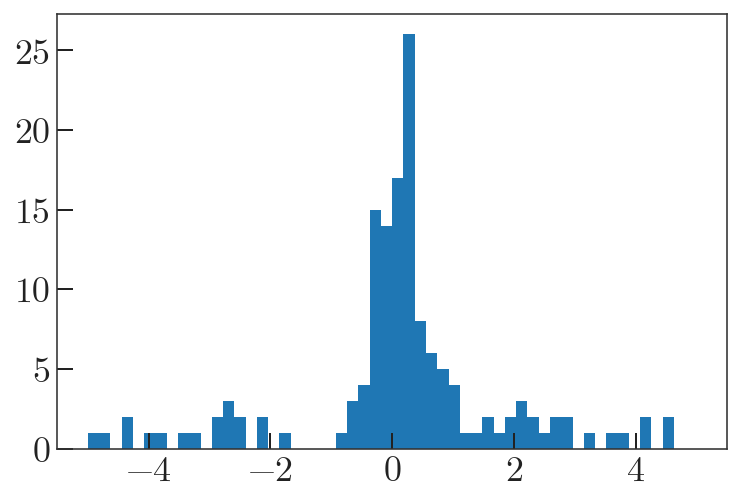

In [209]:
derp = (phi1 > -36*u.deg) & (phi1 < -30*u.deg)
plt.figure()
plt.hist(phi2[derp & cmd_mask & pm_mask], bins=np.linspace(-5, 5, 55));

derp = (phi1 > (-36-10)*u.deg) & (phi1 < (-30-10)*u.deg)
plt.figure()
plt.hist(phi2[derp & cmd_mask & pm_mask], bins=np.linspace(-5, 5, 55));

### Output table with masks:

In [215]:
final_phi1_mask = (phi1 > -100*u.deg) & (phi1 < 25*u.deg)

final_t = g.data[final_phi1_mask]
final_t['pm_mask'] = pm_mask[final_phi1_mask]
final_t['gi_cmd_mask'] = cmd_mask[final_phi1_mask]

final_t['phi1'] = phi1[final_phi1_mask]
final_t['phi2'] = phi2[final_phi1_mask]

final_t['pm_phi1_cosphi2_no_reflex'] = pm1[final_phi1_mask]
final_t['pm_phi2_no_reflex'] = pm2[final_phi1_mask]

final_t['pm_phi1_cosphi2'] = gd1_c_raw.pm_phi1_cosphi2[final_phi1_mask]
final_t['pm_phi2'] = gd1_c_raw.pm_phi2[final_phi1_mask]

len(final_t)

3224608

In [217]:
final_t.write('../data/gd1-with-masks.fits')

In [219]:
final_t.colnames

['solution_id',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'visibility_periods_used',
 'phot_g_n_obs',
 'phot_g_mean_flux',
 'phot_g_mean_flux_error',
 'phot_g_mean_flux_over_error',
 'phot_g_mean_mag',
 'phot_bp_n_obs',
 'phot_bp_mean_flux',
 'phot_bp_mean_flux_error',
 'phot_bp_mean_flux_over_error',
 'phot_bp_mean_mag',
 'phot_rp_n_obs',
 'phot_rp_mean_flux',
 'phot_rp_mean_flux_error',
 'phot_rp_mean_flux_over_error',
 'phot_rp_mean_mag',
 'phot_bp_rp_excess_factor',
 'phot_proc_mode',
 'bp_rp',
 'bp_g',
 'g_rp',
 'radial_velocity',
 'radial_velocity_error',
 'a_g_val',
 'a_g_percentile_lower',
 'a_g_percentile_upper',
 'e_bp_min_rp_val',
